<a href="https://colab.research.google.com/github/Venu2791/Deep-Vision/blob/master/Assignment_11/Assignment_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Assignment 11**

######**Objective:**

*   To find the best learning rate using a LRFinder code suggested in the    assignment.

*   Implement cutout and use gradCAM on 25 misclassified images and plot their heatmaps.




In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
import keras
import cv2
from keras import regularizers,callbacks
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout,GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback,ModelCheckpoint

Using TensorFlow backend.


##Loading dataset

Cifar10 has 10 different classes. Train data : 50000 and Test data : 10000.
Image Resolution :32X32


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


In [3]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


**Sample Plot for CIFAR10:**
1. Create a list for classes in CIFAR10 dataset.
2. Create the subplot figure.
2. Iterate over each class and Pick a random image for each class from the train dataset.
3. Subplot all the classes of CIFAR10 with the appropriate label.

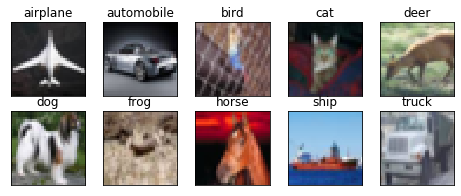

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

The below code is to plot the comparison of loss and accuracy betweeen train and test dataset taking model.fit as argument.

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

##Test Accuracy:
With the trained model, we do the predictions for the test dataset using predict function. We then compute the accuracy.

Accuracy= # of correct predictions/number of samples.

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

##Preprocessing data

1. Convert the image matrices to float and standardize (Dividing by 255) both train and test data. 
2. One-hot coding the train and test labels.

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Data Augumentation -Cutout

**Cutout** is a simple regularization method for convolutional neural networks which consists of masking out random sections of input images during training. This technique simulates occluded examples and encourages the model to take more minor features into consideration when making decisions, rather than relying on the presence of a few major features.

The below code is a randome erasing function with the following parameters:

*   p : the probability that random erasing is performed
*   s_l, s_h : minimum / maximum proportion of erased area against       input image
*   r_1, r_2 : minimum / maximum aspect ratio of erased area
*   v_l, v_h : minimum / maximum value for erased area
*   pixel_level : pixel-level randomization for erased area.


In [0]:
import numpy as np
def get_random_eraser(p=0.6, s_l=0.05, s_h=0.4, r_1=0.3, r_2=1/0.2, v_l=0, v_h=1, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

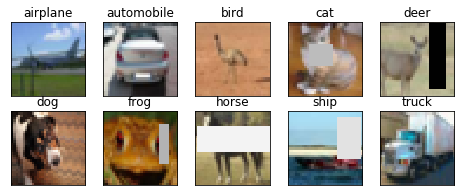

In [9]:
eraser=get_random_eraser()
#plt.imshow(eraser(train_features_1[1,::]))

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(np.argmax(train_labels,axis=1)[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(eraser(im))
plt.show()

Below code shows the model architecture. Following changes were made from initial version:
*   Removed final max pooling layers. 
*   Replaced Flatten with Global Average pooling.




In [0]:
# Define the model
def get_model():
 model = Sequential()
 model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
 model.add(Activation('relu'))
 model.add(BatchNormalization())
 model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
 model.add(Activation('relu'))
 model.add(BatchNormalization())
 model.add(MaxPooling2D(pool_size=(2, 2)))
 model.add(Dropout(0.1))
 model.add(Convolution2D(32, 1, 1))
 model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
 model.add(Activation('relu'))
 model.add(BatchNormalization())
 model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
 model.add(Activation('relu'))
 model.add(BatchNormalization())
 model.add(MaxPooling2D(pool_size=(2, 2)))
 model.add(Dropout(0.1))
 model.add(Convolution2D(32, 1, 1))
 model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
 model.add(Activation('relu'))
 model.add(BatchNormalization())
 model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
 model.add(Activation('relu'))
 model.add(BatchNormalization())
 #model.add(MaxPooling2D(pool_size=(2, 2)))
 model.add(Dropout(0.1))
 model.add(Convolution2D(10, 1, 1))
 model.add(GlobalAveragePooling2D())
 #model.add(Flatten())
 model.add(Activation('softmax'))

 return model
# Compile the model
#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
model=get_model()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)       

**Finding the best Learning Rate:**

Class **LR_Finder** that inherits from the keras class Callback
This is an Abstract class that when inherited needs one or many of the following functions to be over-ridden:

on_batch_end
on_batch_begin
on_epoch_end
on_epoch_begin
on_train_begin
As you can see, we have over-ridden the implementations of on_train_begin and on_batch_end

We do the following on every batch end:
Increase the LR of the optimizer exponentially
Store the loss and the smoothened loss values in separate arrays
Store the current LR to an array
Beta is the smoothening factor that kind of works like momentum in this case
We also check if the current loss has surpassed the best loss by a pre-defined factor - If so - we stop training
Next, we provide various plotting utilities to plot the loss / smoothened loss against the LRs / iterations

In [0]:
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-100], self.losses[n_skip:-100])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-100], self.smoothed_losses[n_skip:-100])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

**Keras Preprocessing** is the data preprocessing and data augmentation module of the Keras deep learning library. It provides utilities for working with image data, text data, and sequence data.One point to note is that we will be able to give only one function in a single preprocessing instance.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,horizontal_flip=False,zoom_range=0.0,preprocessing_function =get_random_eraser())
test_datagen=ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)
datagen.fit(train_features)
test_datagen.fit(test_features)
train_iter=datagen.flow(train_features, train_labels, batch_size = 128)
test_iter=test_datagen.flow(test_features, test_labels,batch_size=10000)

In [15]:
lr_finder = LR_Finder(step_size=np.ceil(train_features.shape[0]/128))
CKPT = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='max', period=1)

# Train the model
#model=get_model()
optim = keras.optimizers.SGD(lr=0.005, momentum=0.5, nesterov=False)
model.compile(optimizer = optim, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(train_iter,samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                   validation_data = test_iter.next(), verbose=1,callbacks =[CKPT,lr_finder])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  # Remove the CWD from sys.path while we load stuff.




Epoch 1/100
390/390 [==============================] - 17s 42ms/step - loss: 2.6822 - acc: 0.2458 - val_loss: 14.9936 - val_acc: 0.0709
Epoch 2/100
  8/390 [..............................] - ETA: 9s - loss: 14.5580 - acc: 0.1016 

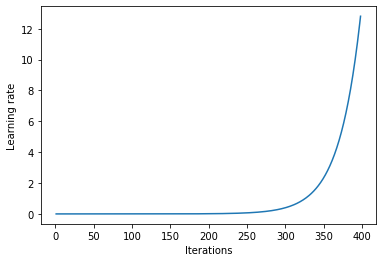

In [16]:
lr_finder.plot_lr()

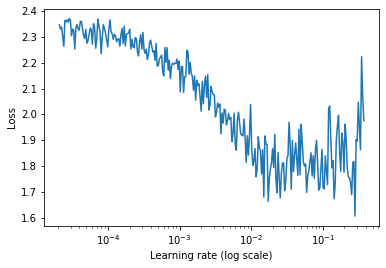

In [17]:
lr_finder.plot(20)

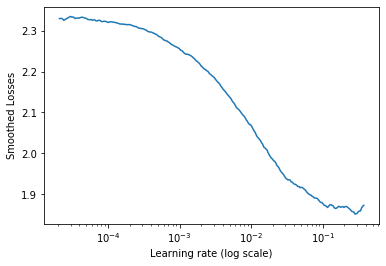

In [18]:
lr_finder.plot_smoothed_loss(20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: 

Epoch 1/100
390/390 [==============================] - 11s 27ms/step - loss: 1.6939 - acc: 0.4011 - val_loss: 1.4158 - val_acc: 0.5060
Epoch 2/100
390/390 [==============================] - 10s 25ms/step - loss: 1.4146 - acc: 0.5067 - val_loss: 1.2704 - val_acc: 0.5555
Epoch 3/100
390/390 [==============================] - 10s 24ms/step - loss: 1.2928 - acc: 0.5566 - val_loss: 1.1920 - val_acc: 0.5878
Epoch 4/100
390/390 [==============================] - 10s 24ms/step - loss: 1.2093 - acc: 0.5829 - val_loss: 1.0739 - val_acc: 0.6272
Epoch 5/100
390/390 [==============================] - 9s 24ms/step - loss: 1.1477 - acc: 0.6070 - val_loss: 1.0464 - val_acc: 0.6376
Epoch 6/100
390/390 [==============================] - 10s 25ms/step - loss: 1.0994 - acc: 0.6237 - val_loss: 1.0332 - val_acc: 0.6455
Epoch 7/100
390/390 [==============================] - 9s 24ms/step - loss: 1.0539 - acc: 0.6417 - val_loss: 0.9724 - val_acc: 0.6634
Epoch 8/100
390/390 [==============================] - 9s

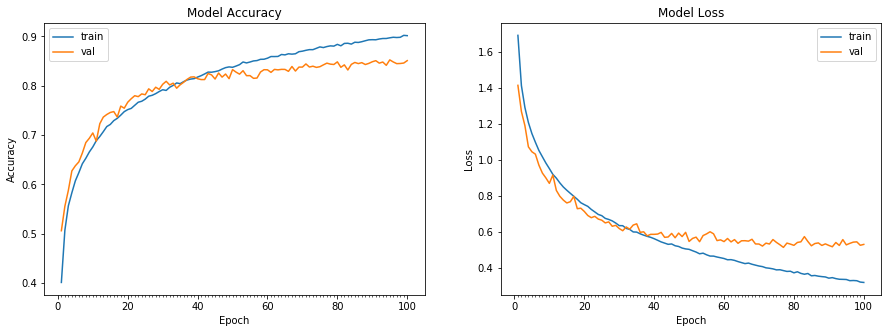

Accuracy on test data is: 85.08


In [19]:
model1=get_model()
optim = keras.optimizers.SGD(lr=0.005, momentum=0.5, nesterov=False)
model1.compile(optimizer = optim, loss='categorical_crossentropy', metrics=['accuracy'])
# train the model
start = time.time()
model_info = model1.fit_generator(train_iter,samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data =  test_iter.next(), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
test_features, test_labels = test_iter.next()
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model1))

**Where is CNN looking? - GradCAM:**

Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target concept (say logits for ‘dog’ or even a caption), flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept.


**What does gradCAM do?**


*   It takes as input - The input image, a pre-trained model and a layer within that model
*   Infer the image and get the topmost class index
*   Take the output of the final convolutional layer
*   Compute the gradient of the class output value w.r.t to L feature maps
*   Pool the gradients over all the axes leaving out the channel dimension
*   Weigh the output feature map with the computed gradients (+ve)
*   Average the weighted feature maps along channels
*   Normalize the heat map to make the values between 0 and 1















In [0]:
def gradCAM(img, model, layer_name):
  class_idx = np.argmax(model.predict(img)[0])
  
  class_output = model.output[:, class_idx]
  layer = model.get_layer(layer_name)
  grads = K.gradients(class_output, layer.output)[0]
  pooled_grads = K.mean(grads, axis = (0, 1, 2))
  iterate = K.function([model.input],[pooled_grads, layer.output[0]])
  pooled_grads_val, layer_output_val = iterate([img])
  for i in range(pooled_grads_val.shape[0]):
    layer_output_val[:,:,i] *= pooled_grads_val[i]
  
  heatmap = np.sum(layer_output_val, axis = 2)
  heatmap = np.maximum(heatmap, 0)
  
  heatmap /= np.max(heatmap)
  
  heatmap = cv2.resize(heatmap, (32,32))
  heatmap = np.uint8(heatmap * 255)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW)
    
  return heatmap

In [0]:
(train_features_1, train_labels_1), (test_features_1, test_labels_1) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features_1.shape
num_test, _, _, _ =  test_features_1.shape
num_classes = len(np.unique(train_labels_1))

In [0]:
train_features_1 = train_features_1.astype('float32')/255
test_features_1 = test_features_1.astype('float32')/255
# convert class labels to binary class labels
train_labels_1 = np_utils.to_categorical(train_labels_1, num_classes)
test_labels_1 = np_utils.to_categorical(test_labels_1, num_classes)

In [0]:
predicted = np.argmax(model.predict(test_datagen.standardize(test_features)), axis = 1)

In [26]:
idx=[index for index, elem in enumerate(np.argmax(test_labels_1,axis=1))  if elem != predicted[index]]
idx=np.random.choice(idx, size = 25, replace = False)
print(idx)

[3889 9582 3523 2291 1339 4330 2158 1293  671 3290 3627 3107 8703 9120
 1848 8153 6770 1511 8870 7481 9155 6923 3451 4232 1184]


In [27]:
model1.predict(test_datagen.standardize(test_features))

array([[1.1580971e-14, 9.9999964e-01, 9.7578217e-13, ..., 3.0720679e-14,
        6.2072142e-18, 3.8282292e-07],
       [4.8268904e-17, 1.0000000e+00, 4.7763512e-11, ..., 9.3829534e-13,
        1.8785544e-19, 2.4926658e-08],
       [3.2459817e-09, 2.8047946e-03, 2.0238654e-06, ..., 1.5784405e-03,
        4.4699771e-20, 5.0265029e-05],
       ...,
       [1.6068492e-15, 9.9979943e-01, 1.3765424e-06, ..., 2.8202753e-11,
        6.0249234e-13, 9.4870520e-06],
       [1.0042157e-07, 1.2838118e-10, 3.5961881e-10, ..., 6.6236191e-04,
        1.5125864e-23, 8.8134133e-10],
       [7.4837022e-17, 6.9572181e-01, 4.7361199e-12, ..., 4.7747558e-06,
        1.4675522e-33, 1.2547361e-05]], dtype=float32)

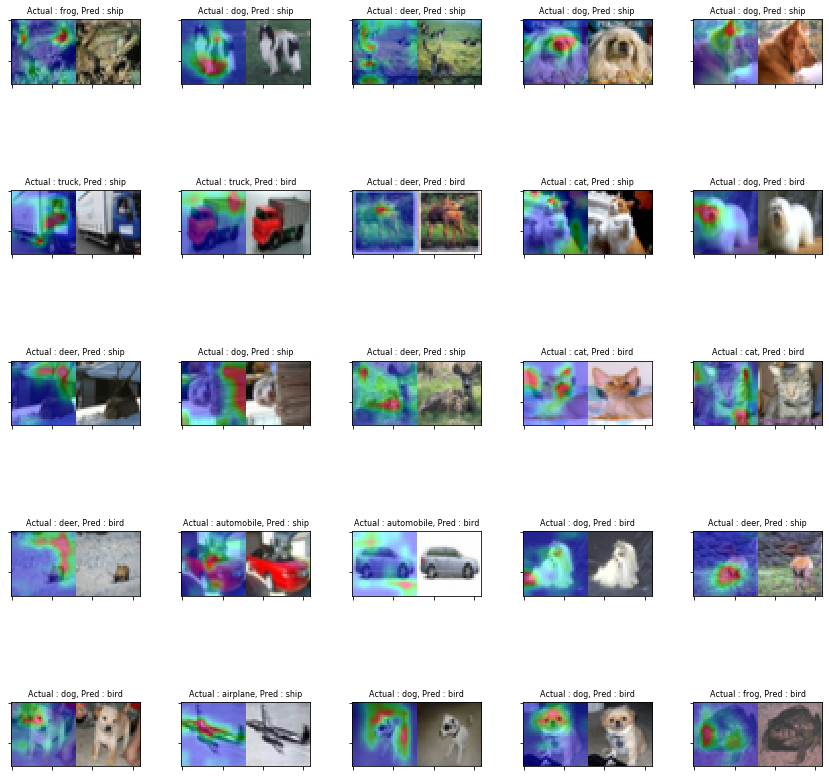

In [28]:
fig, ax = plt.subplots(5,5, figsize = (12,12))
fig.tight_layout()
a=0

for i in range(5):
 for j in range(5):
    #print(test_features)
    img = test_features_1[idx[a],::].reshape([-1,32,32,3])
    #print(img)
    unnormalized_img = test_features_1[idx[a],::]*255
    #print(unnormalized_img)
    heatmap = gradCAM(img,model1,"conv2d_18")
    #print(heatmap)
    superimposed_img = cv2.addWeighted(unnormalized_img, 0.6, heatmap, 0.4, 0, dtype = cv2.CV_32F)/255
    plot_img = np.concatenate((superimposed_img, unnormalized_img/255), axis = 1)
    #plt.imshow(plot_img)
    ax[i, j].imshow(plot_img)
    ax[i, j].set_xticklabels([])
    ax[i, j].set_yticklabels([])
    true_class = class_names[np.argmax(test_labels_1[idx[a],].astype(int))]
    pred_class = class_names[predicted[idx[a]]]
    ax[i,j].set_title("Actual : {}, Pred : {}".format(true_class, pred_class),fontsize=8)
    a += 1